# Missing values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
import random
random.seed(430)

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

We laden hier de heart-disease dataset in, maar we verwijderen allerlei random waarden in de test dataset.
Wij gaan proberen om die waarden zo goed mogelijk in te vullen en een zo hoog mogelijke score te krijgen

In [2]:
df = pd.read_csv("dataset/heart.csv")
print(df.columns)
df.head(5)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# df = df.drop(columns=['oldpeak','trestbps', 'fbs','cp','thal','slope'])
df = df.drop(columns=['age','cp','trestbps','chol','restecg','thalach','oldpeak','slope','ca','thal']) # Binary values only
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=80, random_state=99)

In [4]:
for index, row in X_test.iterrows():
    for x in range(1):
        col_to_clear = random.choice((X_test).columns)
        X_test[col_to_clear][index] = np.nan

In [5]:
print("Train dataset size:",X_train.shape[0])
print("Test dataset size", X_test.shape[0])

Train dataset size: 223
Test dataset size 80


Met deze functie kun je de accuracy van je invulling van missende waarden

In [6]:
clf = RandomForestClassifier(random_state=300)
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=300,
                       verbose=0, warm_start=False)

In [7]:
def test_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_pred, y_test)

Je ziet hieronder dat er aardig wat waarden missen

In [8]:
X_test.head(10)

,sex,fbs,exang
137,1.0,NaN,0.0
262,1.0,0.0,NaN
43,NaN,0.0,0.0
90,NaN,1.0,0.0
32,NaN,0.0,0.0
61,NaN,0.0,0.0
72,1.0,NaN,0.0
10,1.0,NaN,0.0
240,1.0,NaN,1.0
111,NaN,1.0,0.0


Als we alle NaN waarden naar 0 zetten krijgen we een score van 0.66

In [9]:
# All nan values to 0
test_model(clf, X_train, X_test.replace(np.nan,0), y_train, y_test)

0.6875

In [10]:
X_train.columns

Index(['sex', 'fbs', 'exang'], dtype='object')

In [11]:
# All nan values to most common of that target
change_list = []
train_temp = X_train.join(y_train)
test_temp = X_test.join(y_test)
for index, row in test_temp.iterrows():
    row_set = False
    for col, value in row.iteritems():
        if np.isnan(value):
            try:
                if False: #TODO: only binary values (if col in)
                    m = train_temp[train_temp.target == row.target][col].mean()
                else:
                    m = train_temp[train_temp.target == row.target][col].mode()
                X_test[col][index] = m
            except:
                X_test[col][index] = 0
                print("Error:",col)
            
            if row_set == False:
                change_list.append((col,index))
                row_set = True
X_test.head(10)

,sex,fbs,exang
137,1.0,0.0,0.0
262,1.0,0.0,1.0
43,1.0,0.0,0.0
90,1.0,1.0,0.0
32,1.0,0.0,0.0
61,1.0,0.0,0.0
72,1.0,0.0,0.0
10,1.0,0.0,0.0
240,1.0,0.0,1.0
111,1.0,1.0,0.0


In [12]:
# Basic interpreter
test_model(clf, X_train, X_test, y_train, y_test)

0.8375

# Proximity matrix

In [13]:
df_full = pd.concat([X_train, X_test])
leaves = clf.apply(df_full)
n_trees = leaves.shape[1]
proximity_matrix = np.zeros([leaves.shape[0], leaves.shape[0]])
count = df_full.shape[0] * leaves.shape[1]
counter = 0

for tree in leaves.T:
    for rowindex in df_full.index:
        print(counter, '/' ,count, end='')
        clear_output(True)
        counter += 1
        for rowindex2 in df_full.index:
            if tree[rowindex] == tree[rowindex2]:
                proximity_matrix[rowindex, rowindex2] += 1
proximity_matrix /= n_trees

29862 / 30300

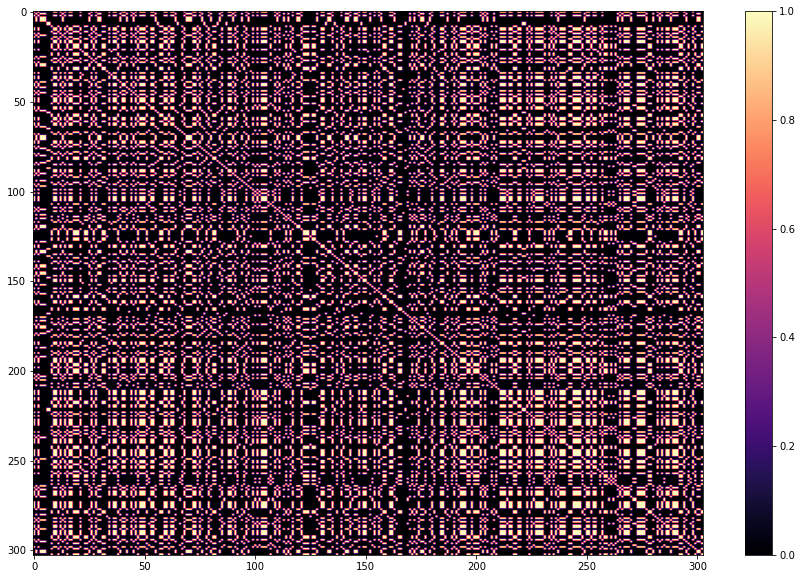

In [17]:
plt.figure(figsize=[15,10])
plt.imshow(proximity_matrix, aspect='auto', cmap='magma')
plt.colorbar()

In [33]:
X_test_proximized = X_test.copy()

change_count = 0
for row in change_list:
    col = row[0]
    index = row[1]
    value = df_full.loc[index, col]
    
    if True: #TODO: Change to binary values (if in [])
        count_yes, count_no = 0, 0
        weight_yes, weight_no = 0, 0
        for ix, weight in enumerate(proximity_matrix[index]):
            if df_full.iloc[ix][col] == 1:
                count_yes += 1
                weight_yes += weight
            else:
                count_no += 1
                weight_no += weight
        
        total = count_no + count_yes
        total_weights = weight_yes + weight_no
        no = (count_no/total) * (weight_no/total_weights)
        yes = (count_yes/total) * (weight_yes/total_weights)
        
        a = X_test_proximized.loc[index,col]
        X_test_proximized.loc[index, col] = (yes >= no)
        b = X_test_proximized.loc[index,col]
        if a != b:
            change_count += 1
            print('changes:',change_count,'==>', test_model(clf, X_train, X_test_proximized, y_train, y_test))
            clear_output(True)

changes: 49 ==> 0.5875


In [30]:
test_model(clf, X_train, X_test_proximized, y_train, y_test)

0.625

In [29]:
print(X_train.columns)
X_train.exang.unique()

array([0, 1], dtype=int64)